# Convoluted Pneumonia Detection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

np.random.seed(42)
tf.random.set_seed(42)

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

2025-02-09 13:24:12.750455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 13:24:12.892805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739125452.957600    8784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739125452.979370    8784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 13:24:13.124087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Notebook last run (end-to-end): 2025-02-09 13:24:14.900628


In [2]:
test_dir = "data/test"
train_dir = "data/train"
validation_dir = "data/val"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

height, width, channels = 150, 150, 3

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='rgb',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='rgb',
)

y_true = test_generator.classes

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# print class labels
print(f"Class labels: {train_generator.class_indices}")

Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


Normal images in test set: 234
Pneumonia images in test set: 390
Normal images in train set: 1341
Pneumonia images in train set: 3875


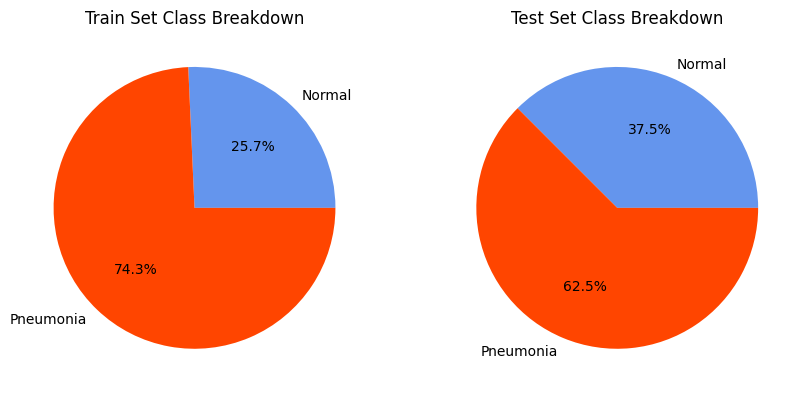

In [4]:
# compare number of images in each category
test_normal_images_count = len(test_generator.classes[test_generator.classes == 0])
test_pneumonia_images_count = len(test_generator.classes[test_generator.classes == 1])

print(f"Normal images in test set: {test_normal_images_count}")
print(f"Pneumonia images in test set: {test_pneumonia_images_count}")

train_normal_images_count = len(train_generator.classes[train_generator.classes == 0])
train_pneumonia_images_count = len(train_generator.classes[train_generator.classes == 1])

print(f"Normal images in train set: {train_normal_images_count}")
print(f"Pneumonia images in train set: {train_pneumonia_images_count}")

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax.flatten()

ax[0].pie([train_normal_images_count, train_pneumonia_images_count],
       labels=[f'Normal', f'Pneumonia'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
ax[0].set_title('Train Set Class Breakdown')
ax[1].pie([test_normal_images_count, test_pneumonia_images_count],
       labels=[f'Normal', f'Pneumonia'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
ax[1].set_title('Test Set Class Breakdown')
plt.show()

There's a clear skew towards pneumonia images, so we can't rely on accuracy: just classifying all images as pneumonia would give over 62.5% test accuracy! We'll refer to the confusion matrix to see true positives, true negatives, false positives, and false negatives, and draw conclusions from there. 

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Convolutional Neural Nets: First Approach

In [6]:
batch_size = 20
epochs = 15

steps_per_epoch = len(train_generator)//batch_size
validation_steps = len(validation_generator)//batch_size

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

2025-02-09 13:24:15.306415: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
# Using CNN configuration from tensorflow tutorial: https://www.tensorflow.org/tutorials/images/cnn
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(height, width, channels)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        18,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,817 (292.25 KB)

 Trainable params: 74,817 (292.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)

/home/sam/Documents/projects/ConvolutedPneumoniaDetection/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.7177 - fn: 0.0000e+00 - fp: 41.0000 - loss: 0.6336 - precision: 0.7177 - recall: 1.0000 - tn: 0.0000e+00 - tp: 107.5714 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.8023 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.7722 - fn: 0.0000e+00 - fp: 36.0714 - loss: 0.5237 - precision: 0.7720 - recall: 1.0000 - tn: 0.2857 - tp: 112.2143 - val_accuracy: 0.5625 - val_fn: 0.0000e+00 - val_fp: 7.0000 - val_loss: 0.6738 - val_precision: 0.5333 - val_recall: 1.0000 - val_tn: 1.0000 - val_tp: 8.0000
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.8364 - fn: 1.6429 - fp: 22.2143 - loss: 0.3939 - precision: 0.8385 - recall: 0.9912 - tn: 5.9286 - tp: 118.7857 - val_accuracy: 0.6250 - val_fn: 0.0000e+00 - val_fp: 6.0000 - val_loss: 0.6551 - val_precision: 0.5714 - val_recall: 1.0000 - val_t

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


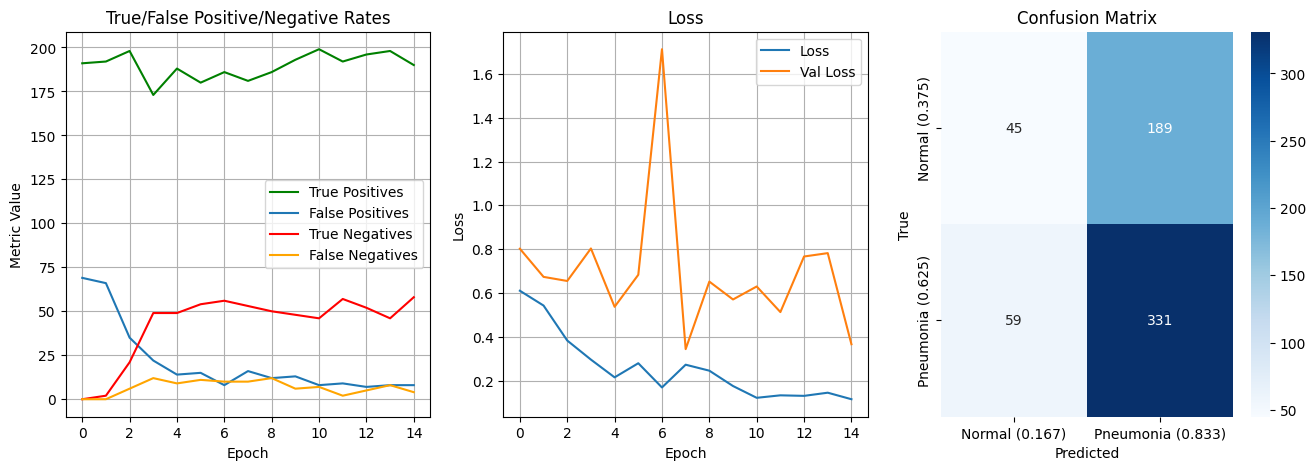

In [12]:
def summary_graphics(history, model):
    y_pred = np.round(model.predict(test_generator))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True/False Positive/Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()

summary_graphics(history, model_1)

What isn't shown here is the roughly dozen additional models I trained based on the model above, all which had roughly identical performance: an extremely high false positive rate, and a false negative rate that made the positive diagnosis basically 50-50 accuracy. It was obvious my models were bad and that I didn't know how to improve them.

Initially, the problem I thought I had was *overfitting* the unbalanced data: clearly pneumonia images were overrepresented, and I thought that if I could penalize the neural net for training to much on the pneumonia images, I would get a confusion matrix that looked closer to the identity (which means few false positives and few false negatives). I emailed my professor, Dr. Wang, at Northeastern, who told me to try resampling (which unfortunately seems a bit tricky with keras generators) or to create class weights, which I implemented following the [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) on imbalanced data.

In [13]:
# from the tensorflow tutorial on imbalanced data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# output bias
output_bias = tf.keras.initializers.Constant(np.log([train_pneumonia_images_count/train_normal_images_count]))

# class weights

weight_for_normal = (1 / train_normal_images_count)*(train_normal_images_count + train_pneumonia_images_count)/2.0
weight_for_pneumonia = (1 / train_pneumonia_images_count)*(train_normal_images_count + train_pneumonia_images_count)/2.0

class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print(f"Weight for normal class: {weight_for_normal:1.3f}")
print(f"Weight for pneumonia class: {weight_for_pneumonia:1.3f}")

Weight for normal class: 1.945
Weight for pneumonia class: 0.673


Introducing the class weights resulted in marginally better performance, but my false negative/positive rates were still very high. Clearly I had misdiagnosed the problem.

So I consulted two sources: I had a copy of [Hands on Machine Learning with Scikit-Learn, Keras \& TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) by Aurélien Géron and decided to consult that. I also looked at the notebooks on the [kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) for the data set, which brought me to the notebook [Beating Everything with Depthwise Convolution](https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution/notebook) by the user Nain. Both discussed Google's [Xception](https://arxiv.org/abs/1610.02357) neural net that trained with depthwise separable convolution.

I based my model on Nain's, which is based off Xception. There were several things he did that I didn't: he preprocessed his data differently, he 

However, I didn't want to do transfer learning: I wanted to see how good (or bad) a fit I could get just starting from initial weights.

## Convolutional Neural Nets: Second Approach

In [14]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(height, width, channels)), # necessary for model summary

    # start with two convolutional layers and then do pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    # the rest of the convolutional layers in the model are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.4pool"),

    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.2conv"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="3.4pool"),

    # model ends with dense layers with dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', name="4.1dense"),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu', name="4.2dense"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="output")
])

epochs = 50

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 1.1conv (Conv2D)                │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (SeparableConv2D)       │ (None, 75, 75, 128)    │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (SeparableConv2D)       │ (None, 75, 75, 128)    │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3conv (SeparableConv2D)       │ (None, 75, 75, 128)    │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.4pool (MaxPooling2D)          │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1dense (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2dense (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,886,913 (41.53 MB)

 Trainable params: 10,886,913 (41.53 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 962ms/step - accuracy: 0.6072 - fn: 34.5714 - fp: 28.0000 - loss: 0.6882 - precision: 0.7629 - recall: 0.6553 - tn: 18.2143 - tp: 83.7857 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5749 - fn: 28.9286 - fp: 35.0000 - loss: 0.7001 - precision: 0.7107 - recall: 0.7194 - tn: 6.9286 - tp: 77.7143 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4557 - fn: 62.7857 - fp: 21.2857 - loss: 0.7118 - precision: 0.6802 - recall: 0.4732 - tn: 17.5000 - tp: 47.0000 - val_accuracy: 0.5000 - val_fn: 8.0000 - val_fp: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn

/home/sam/Documents/projects/ConvolutedPneumoniaDetection/venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5500 - fn: 4.0000 - fp: 5.0000 - loss: 0.6870 - precision: 0.6875 - recall: 0.7333 - tn: 0.0000e+00 - tp: 11.0000 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 22/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6056 - fn: 25.6429 - fp: 31.0000 - loss: 0.7291 - precision: 0.7031 - recall: 0.7574 - tn: 9.6429 - tp: 82.2857 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6215 - fn: 24.5714 - fp: 28.4286 - loss: 0.6825 - precision: 0.7419 - recall: 0.7570 - tn: 6.6429 - tp: 88.9286 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step


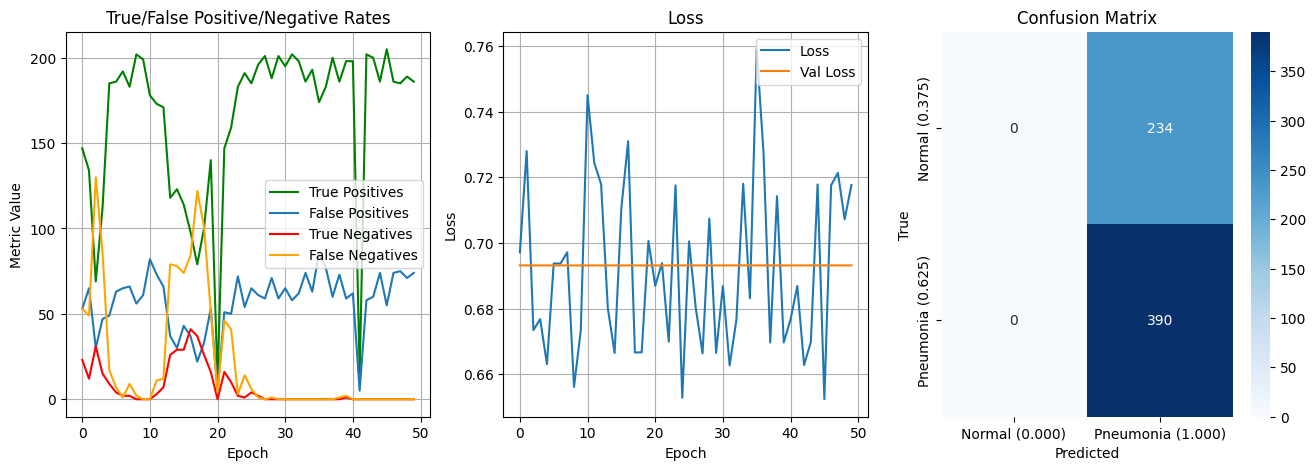

In [16]:
summary_graphics(history, model_2)

## With Transfer Learning from VGG19

Nain's model (and most of the other notebooks on the kaggle page) used transfer learning, which I had been hesitant to try. (Those pretrained models had to have come from somewhere -- why couldn't I just train my own?) But in the interest of making progress and not frying my computer's graphics card, I decided to follow Nain's example and transfer the weights from a VGG model to the first two layers. Nain used VGG16, and since then VGG19 has been released, so I went with VGG19 instead.

In [17]:
vgg19 = tf.keras.applications.VGG19() # default parameters are fine
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(height, width, channels)), # necessary for model summary
    tf.keras.layers.Resizing(244, 244), # VGG layers expect 244x244 images

    # start with two convolutional layers and then do pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    # two more convolutional layers so we can transfer the weights from the VGG19 model to block 2 too
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),

    # the rest of the convolutional layers in Xception are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.2conv"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="3.4pool"),

    # start adding in batch normalization
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.2conv"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="4.4pool"),

    # more convolution layers reduce the number of trainable parameters in the model (but seems to increase training time!)
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.1conv"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.2conv"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="5.4pool"),

    # all the CNN models end with dense layers, probably to help the model "interpret" what the convolutional layers see
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', name="6.1dense"),
    # the above dense layer has 12 million of the 15 million trainable parameters!
    # add in a dropout layer with a high rate to prevent overfitting
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(512, activation='relu', name="6.2dense"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="output")
])

# load the weights from the pre-trained model and freeze the layers
model_3.get_layer('1.1conv').set_weights(vgg19.get_layer('block1_conv1').get_weights())
model_3.get_layer('1.2conv').set_weights(vgg19.get_layer('block1_conv2').get_weights())

model_3.get_layer('1.1conv').trainable = False
model_3.get_layer('1.2conv').trainable = False

model_3.get_layer('2.1conv').set_weights(vgg19.get_layer('block2_conv1').get_weights())
model_3.get_layer('2.2conv').set_weights(vgg19.get_layer('block2_conv2').get_weights())

model_3.get_layer('2.1conv').trainable = False
model_3.get_layer('2.2conv').trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 244, 244, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.3conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.4pool (MaxPooling2D)          │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.1conv (SeparableConv2D)       │ (None, 15, 15, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2conv (SeparableConv2D)       │ (None, 15, 15, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.3conv (SeparableConv2D)       │ (None, 15, 15, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4pool (MaxPooling2D)          │ (None, 7, 7, 512)      │             

 Total params: 15,017,665 (57.29 MB)

 Trainable params: 14,753,409 (56.28 MB)

 Non-trainable params: 264,256 (1.01 MB)

In [23]:
# train the model on 20 epochs with the initial layers frozen
epochs = 20

history = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7183 - fn: 120.2857 - fp: 2.0000 - loss: 0.7402 - precision: 0.9892 - recall: 0.6273 - tn: 103.2857 - tp: 183.0000 - val_accuracy: 0.5000 - val_fn: 8.0000 - val_fp: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2563 - fn: 110.9286 - fp: 0.0000e+00 - loss: 0.6924 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 37.6429 - tp: 0.0000e+00 - val_accuracy: 0.5000 - val_fn: 8.0000 - val_fp: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2199 - fn: 111.0000 - fp: 1.2143 - loss: 0.6541 - precision: 0.5939 - recall: 0.0168 - tn: 34.0000 - tp: 2.3571 - val_accuracy: 0.5000 - val_fn: 8.0000 - val_fp: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - v

32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


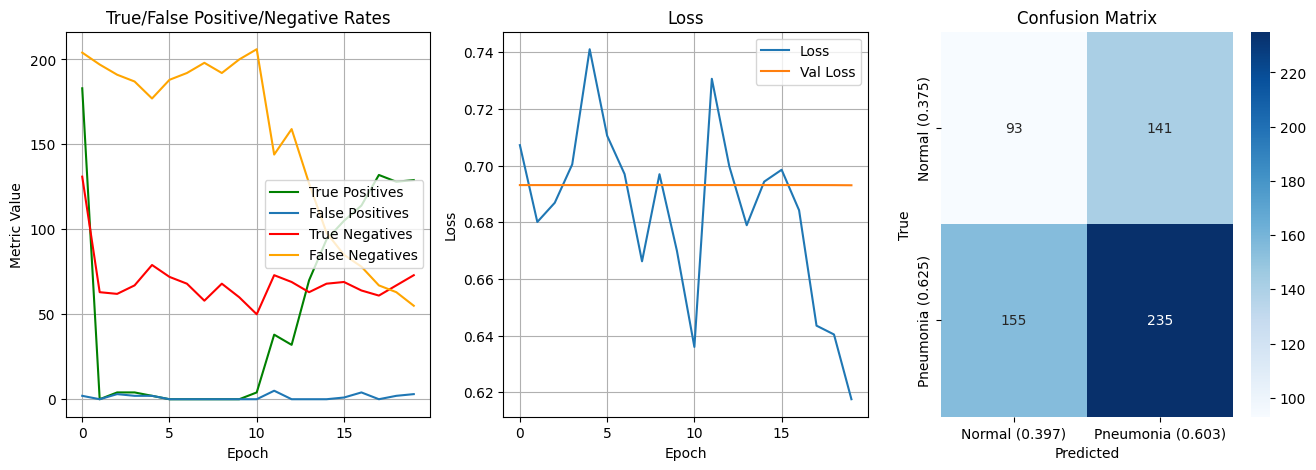

In [24]:
# to generate confusion matrix and classification report
summary_graphics(history, model_3)

In [25]:
# now unfreeze half the layers and train for another 20 epochs
#model_3.get_layer('1.1conv').trainable = False
#model_3.get_layer('1.2conv').trainable = False
model_3.get_layer('2.1conv').trainable = True
model_3.get_layer('2.2conv').trainable = True

# use a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model_3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

history2 = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7701 - fn: 33.6429 - fp: 5.2143 - loss: 0.5641 - precision: 0.9258 - recall: 0.7270 - tn: 42.6429 - tp: 83.0714 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6931 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7748 - fn: 30.5714 - fp: 0.0000e+00 - loss: 0.5385 - precision: 1.0000 - recall: 0.6963 - tn: 40.9286 - tp: 77.0714 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6930 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7542 - fn: 32.1429 - fp: 0.6429 - loss: 0.5381 - precision: 0.9949 - recall: 0.6821 - tn: 37.2143 - tp: 78.5714 - val_accuracy: 0.5000 - val_fn: 0.0000e+00 - val_fp: 8.0000 - val_loss: 0.6930 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e

32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


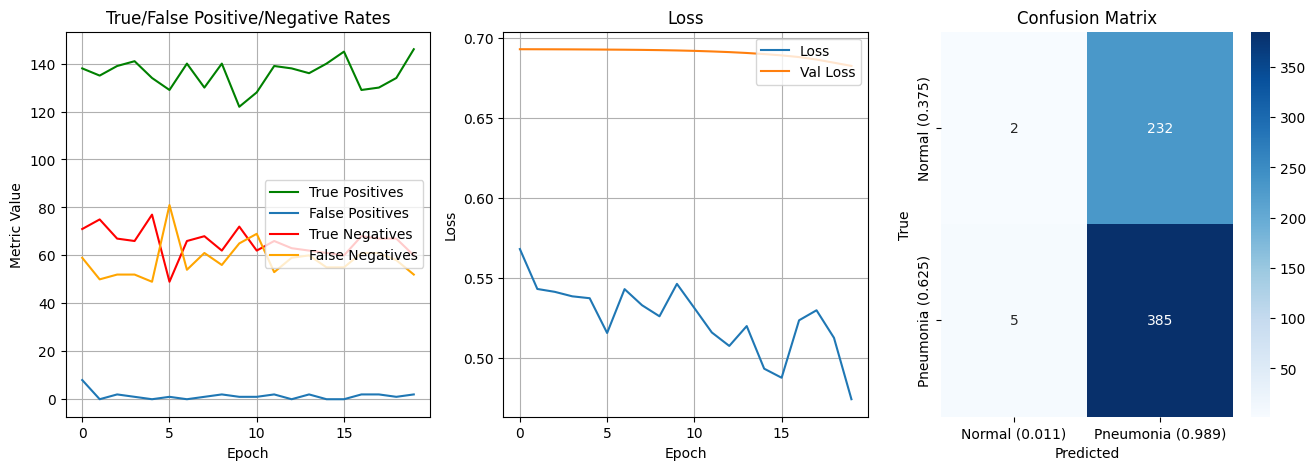

In [26]:
summary_graphics(history2, model_3)

In [28]:
# now unfreeze all the layers and train for another 20 epochs
model_3.get_layer('1.1conv').trainable = True
model_3.get_layer('1.2conv').trainable = True

model_3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

history3 = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
summary_graphics(history3, model_3)

In [ ]:
# model_6.metrics[1]._user_metrics[0]

## Conclusion

In [ ]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")